In [1]:
!pip install perceval-quandela==0.12.0 torch torchvision matplotlib numpy pandas

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

import perceval as pcvl
import perceval.providers.scaleway as scw
from boson_sampler import BosonSampler
from utils import MNIST_partial, plot_training_metrics
from torch.utils.data import Dataset


In [39]:
import os
os.environ["SCW_PROJECT_ID"] = "5303a5ba-7e81-41a8-bcaf-937620e6dea6"
os.environ["SCW_SECRET_KEY"] = "7ec92326-858b-4275-b147-2e09351fbde9"


In [40]:
scw_project_id = os.environ.get("SCW_PROJECT_ID")
scw_token = os.environ.get("SCW_SECRET_KEY")
if scw_project_id is None or scw_token is None:
    raise ValueError("Please set SCW_PROJECT_ID and SCW_SECRET_KEY environment variables.")

def create_session():
    s = scw.Session(
        project_id=scw_project_id,
        token=scw_token,
        platform="sim:sampling:l4",  # Using Scaleway's remote simulation
        max_idle_duration_s=4800,
        max_duration_s=10800,
        deduplication_id="my-photonic-session-pool"
    )
    s.start()
    return s

num_sessions = 4
session = [create_session() for _ in range(num_sessions)]
print(f"Created a pool of {len(session)} sessions.")

Created a pool of 4 sessions.


In [4]:
print(session)


[<perceval.providers.scaleway.scaleway_session.Session object at 0x0000017E78320F10>, <perceval.providers.scaleway.scaleway_session.Session object at 0x0000017E1C78D550>, <perceval.providers.scaleway.scaleway_session.Session object at 0x0000017E78DF3410>, <perceval.providers.scaleway.scaleway_session.Session object at 0x0000017E49A51010>]


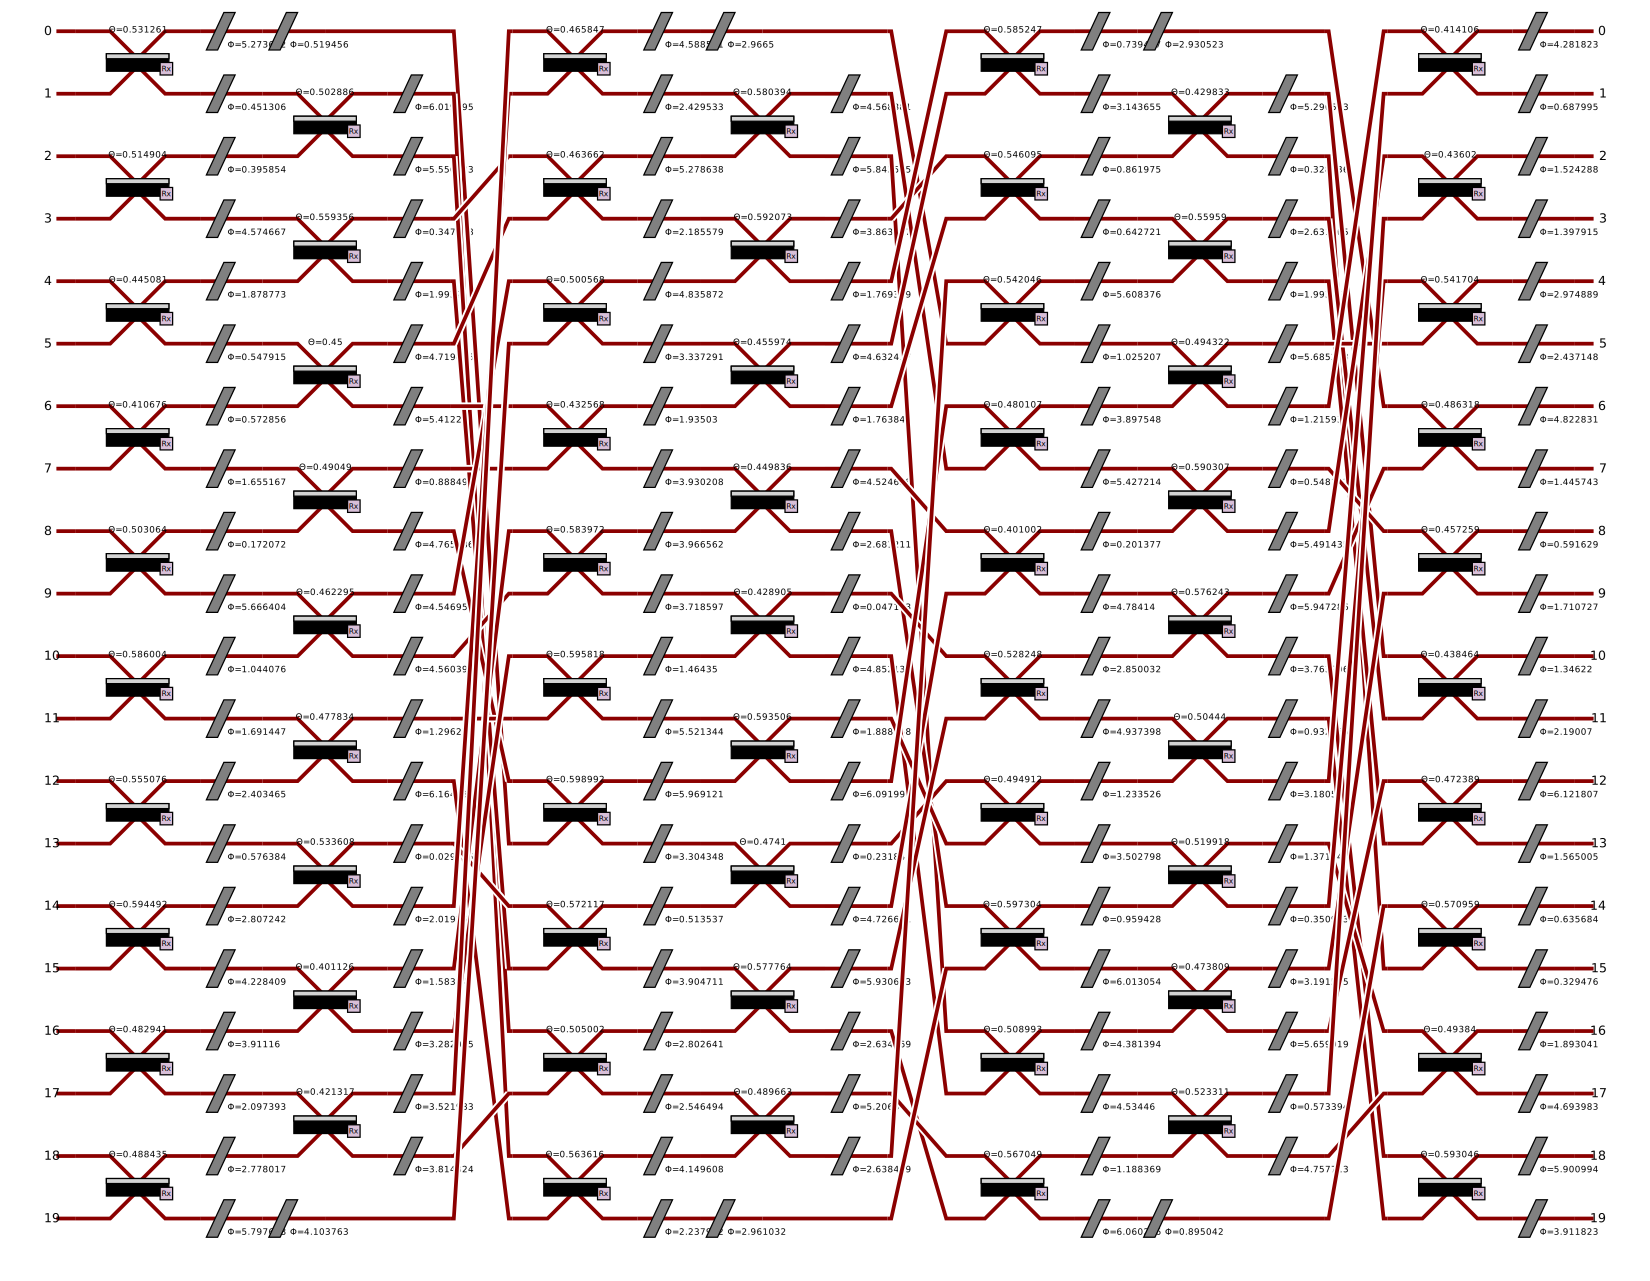

In [41]:

# %% [markdown]
# ## 2. High-Entanglement Circuit Builder for 20 Modes
#
# This function builds a circuit with 20 modes and a depth of 7 layers.
# Each layer adds beam splitters with random reflectivity (0.3 to 0.7) and random phase shifters.
 
# %% [code]
import random
def build_high_entanglement_circuit(modes=20, depth=7):
    circuit = pcvl.Circuit(modes)

    for layer in range(depth):
        # 1. Staggered Beam Splitters
        start = 0 if layer % 2 == 0 else 1
        for i in range(start, modes - 1, 2):
            r = random.uniform(0.4, 0.6)  # Balanced
            circuit.add((i, i+1), pcvl.BS(r))

        # 2. Phase Shifters on all modes
        for i in range(modes):
            circuit.add(i, pcvl.PS(random.uniform(0, 2 * np.pi)))

        # 3. Optional Permutation Layer
        if layer % 2 == 1:
            perm = list(range(modes))
            random.shuffle(perm)
            circuit.add(0, pcvl.PERM(perm))  # 👈 CORRECTED HERE

    return circuit
circuit = build_high_entanglement_circuit(modes=20, depth=7)
pcvl.pdisplay(circuit, file="photonic_circuit_20m7d.svg")


In [6]:
BosonSampler initialized with m=25, n=10. Embedding feature length = 3268760.


SyntaxError: invalid syntax (3741490125.py, line 1)

Pure CNN baseline(without quantum embedding)

In [7]:
# CNN Baseline
class CNN(nn.Module):
    def __init__(self, embedding_size=0):
        super(CNN, self).__init__()
        self.embedding_size = embedding_size
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3136, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x, emb=None):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [8]:

transform = transforms.Compose([])  # or just None

# Load MNIST
train_dataset = MNIST_partial(data="D:\Perceval", transform=None, split='train')
val_dataset   = MNIST_partial(data="D:\Perceval", transform=None, split='val')
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [12]:
baseline_train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
baseline_val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [44]:

# %% [markdown]
# ## 3. Define the Classical CNN Model (HybridCNN)
# 
# HybridCNN acts as a pure CNN when embedding_size==0, otherwise it concatenates a quantum embedding.

# %% [code]
class HybridCNN(nn.Module):
    def __init__(self, embedding_size=0):
        super(HybridCNN, self).__init__()
        self.embedding_size = embedding_size
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = None  # Dynamically initialized in forward.
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x, emb=None):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.flatten(x)  # Expected shape: [batch_size, 3136]
        if emb is None and self.embedding_size > 0:
            classical_data = np.random.rand(25)  # 25 values (one per mode)
            emb = generate_quantum_embedding(classical_data, modes=25, depth=5, session=None)
            emb = emb.to(x.device)
        if emb is not None:
            if len(emb.shape) == 1:
                emb = emb.unsqueeze(0)
            if emb.shape[0] != x.shape[0]:
                emb = emb.repeat(x.shape[0], 1)
            x = torch.cat((x, emb), dim=1)
        if self.fc1 is None:
            input_dim = x.shape[1]
            self.fc1 = nn.Linear(input_dim, 128).to(x.device)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [45]:
import torch
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [13]:

# Accuracy evaluation
def evaluate_accuracy(model, val_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predictions = outputs.argmax(dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    return correct / total

# Single training run
def train_classical_baseline(model, optimizer, dataloader, val_loader, criterion, epochs=10):
    run_metrics = []  # store per-epoch results
    start_time = time.time()
    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for images, labels in tqdm(dataloader, desc=f"[Epoch {epoch+1}]", leave=False):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            correct += (outputs.argmax(dim=1) == labels).sum().item()
            total += labels.size(0)
        train_acc = correct / total
        val_acc = evaluate_accuracy(model, val_loader)
        run_metrics.append({
            "epoch": epoch + 1,
            "train_acc": train_acc,
            "val_acc": val_acc
        })
        print(f"Epoch {epoch+1}: Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")
    duration = time.time() - start_time
    return run_metrics, duration

# Main loop: 10 repeated runs
all_metrics = []
num_runs = 10
epochs = 10

print(">>> Repeated Training: Classical CNN (Baseline Only)")
for run in range(1, num_runs + 1):
    cnn_model = CNN().to(device)
    optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    run_metrics, duration = train_classical_baseline(
        cnn_model, optimizer, baseline_train_loader, baseline_val_loader, criterion, epochs=epochs
    )
    param_count = sum(p.numel() for p in cnn_model.parameters())
    for entry in run_metrics:
        all_metrics.append({
            "run": run,
            "epoch": entry["epoch"],
            "train_acc": entry["train_acc"],
            "val_acc": entry["val_acc"],
            "params": param_count,
            "duration_sec": duration
        })
    print(f"✅ Completed Run {run} in {duration:.2f} seconds\n")

# Save to CSV
os.makedirs("results", exist_ok=True)
df = pd.DataFrame(all_metrics)
df.to_csv("results/cnn_baseline_metrics_10runs.csv", index=False)
print("📊 Results saved to results/cnn_baseline_metrics_10runs.csv")


>>> Repeated Training: Classical CNN (Baseline Only)


Epoch 1: Train Acc = 0.7957, Val Acc = 0.9183


Epoch 2: Train Acc = 0.9508, Val Acc = 0.9467


Epoch 3: Train Acc = 0.9652, Val Acc = 0.9617


Epoch 4: Train Acc = 0.9783, Val Acc = 0.9750


Epoch 5: Train Acc = 0.9842, Val Acc = 0.9750


Epoch 6: Train Acc = 0.9887, Val Acc = 0.9733


Epoch 7: Train Acc = 0.9890, Val Acc = 0.9817


Epoch 8: Train Acc = 0.9937, Val Acc = 0.9750


Epoch 9: Train Acc = 0.9957, Val Acc = 0.9750


Epoch 10: Train Acc = 0.9953, Val Acc = 0.9767
✅ Completed Run 1 in 93.70 seconds



Epoch 1: Train Acc = 0.8187, Val Acc = 0.9300


Epoch 2: Train Acc = 0.9577, Val Acc = 0.9633


Epoch 3: Train Acc = 0.9717, Val Acc = 0.9683


Epoch 4: Train Acc = 0.9803, Val Acc = 0.9667


Epoch 5: Train Acc = 0.9852, Val Acc = 0.9800


Epoch 6: Train Acc = 0.9902, Val Acc = 0.9783


Epoch 7: Train Acc = 0.9913, Val Acc = 0.9750


Epoch 8: Train Acc = 0.9955, Val Acc = 0.9817


Epoch 9: Train Acc = 0.9938, Val Acc = 0.9733


Epoch 10: Train Acc = 0.9992, Val Acc = 0.9800
✅ Completed Run 2 in 137.16 seconds



Epoch 1: Train Acc = 0.8232, Val Acc = 0.9417


Epoch 2: Train Acc = 0.9593, Val Acc = 0.9617


Epoch 3: Train Acc = 0.9753, Val Acc = 0.9717


Epoch 4: Train Acc = 0.9852, Val Acc = 0.9700


Epoch 5: Train Acc = 0.9873, Val Acc = 0.9783


Epoch 6: Train Acc = 0.9925, Val Acc = 0.9817


Epoch 7: Train Acc = 0.9943, Val Acc = 0.9733


Epoch 8: Train Acc = 0.9970, Val Acc = 0.9783


Epoch 9: Train Acc = 0.9962, Val Acc = 0.9750


Epoch 10: Train Acc = 0.9978, Val Acc = 0.9800
✅ Completed Run 3 in 194.16 seconds



Epoch 1: Train Acc = 0.8090, Val Acc = 0.9283


Epoch 2: Train Acc = 0.9538, Val Acc = 0.9583


Epoch 3: Train Acc = 0.9707, Val Acc = 0.9683


Epoch 4: Train Acc = 0.9798, Val Acc = 0.9783


Epoch 5: Train Acc = 0.9838, Val Acc = 0.9717


Epoch 6: Train Acc = 0.9897, Val Acc = 0.9750


Epoch 7: Train Acc = 0.9945, Val Acc = 0.9667


Epoch 8: Train Acc = 0.9955, Val Acc = 0.9817


Epoch 9: Train Acc = 0.9948, Val Acc = 0.9767


Epoch 10: Train Acc = 0.9932, Val Acc = 0.9800
✅ Completed Run 4 in 145.92 seconds



Epoch 1: Train Acc = 0.7928, Val Acc = 0.9417


Epoch 2: Train Acc = 0.9525, Val Acc = 0.9550


Epoch 3: Train Acc = 0.9713, Val Acc = 0.9600


Epoch 4: Train Acc = 0.9797, Val Acc = 0.9633


Epoch 5: Train Acc = 0.9878, Val Acc = 0.9750


Epoch 6: Train Acc = 0.9865, Val Acc = 0.9700


Epoch 7: Train Acc = 0.9918, Val Acc = 0.9733


Epoch 8: Train Acc = 0.9928, Val Acc = 0.9750


Epoch 9: Train Acc = 0.9945, Val Acc = 0.9733


Epoch 10: Train Acc = 0.9968, Val Acc = 0.9717
✅ Completed Run 5 in 156.26 seconds



Epoch 1: Train Acc = 0.8170, Val Acc = 0.9400


Epoch 2: Train Acc = 0.9520, Val Acc = 0.9583


Epoch 3: Train Acc = 0.9722, Val Acc = 0.9450


Epoch 4: Train Acc = 0.9805, Val Acc = 0.9650


Epoch 5: Train Acc = 0.9853, Val Acc = 0.9617


Epoch 6: Train Acc = 0.9893, Val Acc = 0.9767


Epoch 7: Train Acc = 0.9942, Val Acc = 0.9783


Epoch 8: Train Acc = 0.9948, Val Acc = 0.9733


Epoch 9: Train Acc = 0.9967, Val Acc = 0.9800


Epoch 10: Train Acc = 0.9937, Val Acc = 0.9717
✅ Completed Run 6 in 156.32 seconds



Epoch 1: Train Acc = 0.8060, Val Acc = 0.9367


Epoch 2: Train Acc = 0.9527, Val Acc = 0.9583


Epoch 3: Train Acc = 0.9697, Val Acc = 0.9700


Epoch 4: Train Acc = 0.9787, Val Acc = 0.9683


Epoch 5: Train Acc = 0.9840, Val Acc = 0.9717


Epoch 6: Train Acc = 0.9882, Val Acc = 0.9750


Epoch 7: Train Acc = 0.9927, Val Acc = 0.9783


Epoch 8: Train Acc = 0.9958, Val Acc = 0.9717


Epoch 9: Train Acc = 0.9950, Val Acc = 0.9717


Epoch 10: Train Acc = 0.9970, Val Acc = 0.9817
✅ Completed Run 7 in 170.66 seconds



Epoch 1: Train Acc = 0.8190, Val Acc = 0.9267


Epoch 2: Train Acc = 0.9513, Val Acc = 0.9683


Epoch 3: Train Acc = 0.9667, Val Acc = 0.9617


Epoch 4: Train Acc = 0.9748, Val Acc = 0.9750


Epoch 5: Train Acc = 0.9817, Val Acc = 0.9550


Epoch 6: Train Acc = 0.9883, Val Acc = 0.9617


Epoch 7: Train Acc = 0.9907, Val Acc = 0.9700


Epoch 8: Train Acc = 0.9930, Val Acc = 0.9650


Epoch 9: Train Acc = 0.9957, Val Acc = 0.9717


Epoch 10: Train Acc = 0.9955, Val Acc = 0.9733
✅ Completed Run 8 in 156.46 seconds



Epoch 1: Train Acc = 0.8207, Val Acc = 0.9267


Epoch 2: Train Acc = 0.9593, Val Acc = 0.9600


Epoch 3: Train Acc = 0.9733, Val Acc = 0.9667


Epoch 4: Train Acc = 0.9813, Val Acc = 0.9700


Epoch 5: Train Acc = 0.9860, Val Acc = 0.9750


Epoch 6: Train Acc = 0.9912, Val Acc = 0.9700


Epoch 7: Train Acc = 0.9928, Val Acc = 0.9683


Epoch 8: Train Acc = 0.9960, Val Acc = 0.9783


Epoch 9: Train Acc = 0.9960, Val Acc = 0.9767


Epoch 10: Train Acc = 0.9998, Val Acc = 0.9767
✅ Completed Run 9 in 124.68 seconds



Epoch 1: Train Acc = 0.8068, Val Acc = 0.9333


Epoch 2: Train Acc = 0.9515, Val Acc = 0.9500


Epoch 3: Train Acc = 0.9703, Val Acc = 0.9650


Epoch 4: Train Acc = 0.9800, Val Acc = 0.9667


Epoch 5: Train Acc = 0.9870, Val Acc = 0.9800


Epoch 6: Train Acc = 0.9892, Val Acc = 0.9700


Epoch 7: Train Acc = 0.9932, Val Acc = 0.9800


Epoch 8: Train Acc = 0.9948, Val Acc = 0.9833


Epoch 9: Train Acc = 0.9965, Val Acc = 0.9750


Epoch 10: Train Acc = 0.9958, Val Acc = 0.9717
✅ Completed Run 10 in 127.94 seconds

📊 Results saved to results/cnn_baseline_metrics_10runs.csv


In [14]:
# Load the saved metrics (if not already in memory)
df = pd.read_csv("results/cnn_baseline_metrics_10runs.csv")

# Filter for the final epoch of each run
final_epoch_df = df[df["epoch"] == df["epoch"].max()]

# Compute mean and standard deviation
mean_train_acc = final_epoch_df["train_acc"].mean()
std_train_acc  = final_epoch_df["train_acc"].std()

mean_val_acc = final_epoch_df["val_acc"].mean()
std_val_acc  = final_epoch_df["val_acc"].std()

print(f"📈 Final Epoch Accuracy (across {num_runs} runs):")
print(f"Train Accuracy: {mean_train_acc:.4f} ± {std_train_acc:.4f}")
print(f"Val Accuracy:   {mean_val_acc:.4f} ± {std_val_acc:.4f}")


📈 Final Epoch Accuracy (across 10 runs):
Train Accuracy: 0.9964 ± 0.0022
Val Accuracy:   0.9763 ± 0.0040


In [47]:
def analyze_circuit_entanglement(circuit, session, input_state=None, samples=1000):
    if input_state is None:
        input_state = pcvl.BasicState([1]*circuit.m)

    processor = session.build_remote_processor()
    processor.set_circuit(circuit)
    processor.with_input(input_state)

    sampler = pcvl.algorithm.Sampler(processor, max_shots_per_call=samples)
    job = sampler.probs(samples)
    prob_dist = job.get("results")

    # 1. Shannon Entropy
    p_vals = np.array(list(prob_dist.values()))
    p_vals = p_vals[p_vals > 0]
    entropy = -np.sum(p_vals * np.log2(p_vals))

    # 2. Photon Correlation Matrix
    matrix = np.zeros((circuit.m, circuit.m))
    for key, prob in prob_dist.items():
        for i in range(circuit.m):
            for j in range(circuit.m):
                matrix[i, j] += key[i] * key[j] * prob

    # 3. Off-Diagonal Correlation Average
    off_diag = matrix.copy()
    np.fill_diagonal(off_diag, 0)
    avg_off_diag_corr = np.mean(off_diag)

    # --- Visualization ---
    print(f"Shannon Entropy: {entropy:.4f}")
    print(f"Average Off-Diagonal Correlation: {avg_off_diag_corr:.4f}")

    plt.figure(figsize=(15, 10))
    sns.heatmap(matrix, annot=False, cmap="viridis", fmt=".2f")
    plt.title("Photon Correlation Heatmap")
    plt.xlabel("Mode i")
    plt.ylabel("Mode j")
    plt.show()

    return entropy, avg_off_diag_corr, matrix

Shannon Entropy: 9.9658
Average Off-Diagonal Correlation: 0.9081


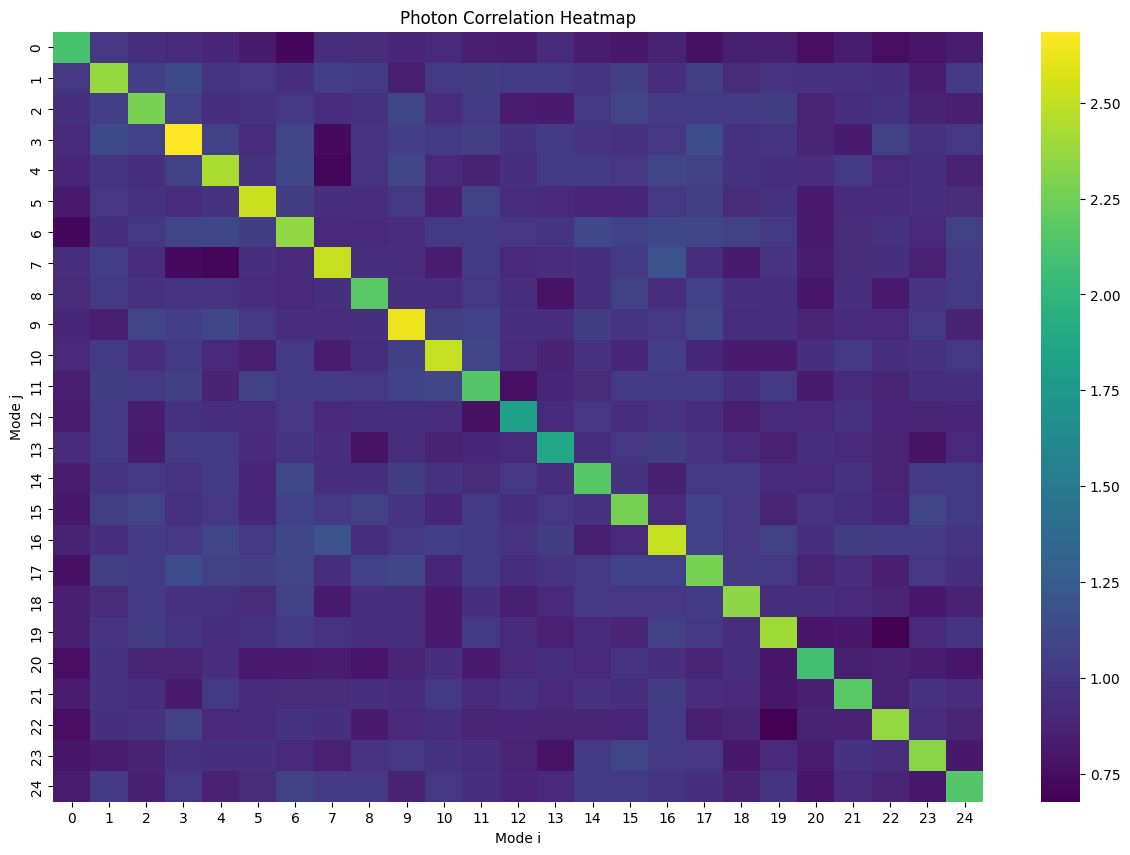

In [49]:
circuit_enhanced = build_high_entanglement_circuit(modes=25, depth=10)
pcvl.pdisplay(circuit_enhanced)

entropy, avg_corr, matrix = analyze_circuit_entanglement(
    circuit_enhanced,
    session=session[0],
    input_state=pcvl.BasicState([1]*25),
    samples=1000
)


With Quantum embedding

In [18]:
MAX_EMBEDDING_DIM = 2000
modes = 25
photons = 10

def encode_classical_data(circuit, data_vector):
    """
    Encode a classical data vector into the circuit by setting phase shifters.
    Here we add a phase shift of 2π * pixel_value at each mode (for the first len(data_vector) modes).
    """
    for i, value in enumerate(data_vector):
        if i >= modes:
            break  # only encode up to 'modes' values
        phase = 2 * np.pi * float(value)  # scale [0,1] value to [0, 2π]
        circuit.add(i % modes, pcvl.PS(phase))
    # Note: This simplistic encoding adds additional phase shifters; alternatively, one could adjust existing ones.

def generate_quantum_embedding(data_vector, session, modes=modes, photons=photons, depth=7):
    """
    Generate a quantum embedding for a given data vector using a boson-sampling photonic circuit.
    Returns a numpy array of length MAX_EMBEDDING_DIM containing the top probabilities from the output distribution.
    """
    try:
        # Build a fresh random circuit and encode data
        circuit = build_high_entanglement_circuit(modes=modes, depth=depth)
        encode_classical_data(circuit, data_vector)
        # Prepare a processor on the given session with the circuit and input state
        processor = session.build_remote_processor()  # remote quantum processor
        processor.set_circuit(circuit)
        # Input state: 'photons' single photons in the first 'photons' modes (1 photon per mode, others empty)
        input_state = pcvl.BasicState([1]*photons + [0]*(modes - photons))
        processor.with_input(input_state)
        # Use Perceval's sampler to get output probabilities with a finite number of shots
        sampler = pcvl.algorithm.Sampler(processor, max_shots_per_call=1000)
        job = sampler.probs(1000)  # perform 1000 measurement shots to estimate probabilities
        raw_distribution = job.get("results")
        if not raw_distribution:
            raise RuntimeError("Sampling job returned no results (possible session issue).")
        # Sort outcomes by probability and take the top MAX_EMBEDDING_DIM
        sorted_keys = sorted(raw_distribution.keys(), key=lambda k: raw_distribution[k], reverse=True)
        top_keys = sorted_keys[:MAX_EMBEDDING_DIM]
        # Create embedding vector of length MAX_EMBEDDING_DIM
        embedding = np.zeros(MAX_EMBEDDING_DIM, dtype=np.float32)
        for idx, state in enumerate(top_keys):
            embedding[idx] = raw_distribution[state]
        return embedding
    except Exception as e:
        # If any error occurs (network issue, session timeout, etc.), restart session and retry once
        print(f"Warning: embedding generation error: {e}. Restarting session and retrying...")
        try:
            session.start()  # attempt to restart the session
        except Exception as e2:
            print(f"Failed to restart session: {e2}")
        # Recursive retry (be careful with infinite recursion in persistent failure)
        return generate_quantum_embedding(data_vector, session, modes, photons, depth)

In [25]:
import threading

def cache_quantum_embeddings(dataset, session_pool, modes=modes, photons=photons):
    """
    Generate quantum embeddings for all samples in the given dataset using multiple sessions in parallel.
    Returns a tensor of shape [len(dataset), MAX_EMBEDDING_DIM] containing embeddings for each data sample.
    """
    n = len(dataset)
    embeddings = [None] * n  # placeholder list for results
    # Progress bar to monitor embedding generation
    progress = tqdm(total=n, desc="Generating Quantum Embeddings", position=0, leave=True)
    progress_lock = threading.Lock()

    def worker(session_idx):
        """Thread worker function: generate embeddings for all indices assigned to this session."""
        sess = session_pool[session_idx]
        # Each thread handles indices session_idx, session_idx+num_sessions, session_idx+2*num_sessions, ...
        for i in range(session_idx, n, len(session_pool)):
            image, label = dataset[i]   # get data sample
            # Flatten image to a 1D vector and take the first 'modes' elements for embedding input
            # (Image is 28x28=784 pixels; we use a 25-length subset for the photonic circuit input)
            img_vector = image.flatten().numpy()
            data_vector = img_vector[:modes]  # length 25
            # Generate embedding using this thread's session
            emb = generate_quantum_embedding(data_vector, session=sess, modes=modes, photons=photons)
            embeddings[i] = torch.tensor(emb, dtype=torch.float32)
            # Update progress bar
            with progress_lock:
                progress.update(1)

    # Launch one thread per session
    threads = []
    for idx in range(len(session_pool)):
        t = threading.Thread(target=worker, args=(idx,))
        t.daemon = True  # daemon threads will quit if main program quits
        threads.append(t)
        t.start()
    # Wait for all threads to complete
    for t in threads:
        t.join()
    progress.close()
    # Stack list of embeddings into a single tensor
    embedding_tensor = torch.stack(embeddings)
    return embedding_tensor

# Generate and cache quantum embeddings for training and validation sets
print("Precomputing quantum embeddings for the training set...")
train_embeddings = cache_quantum_embeddings(train_dataset, session)

print("Precomputing quantum embeddings for the validation set...")
val_embeddings = cache_quantum_embeddings(val_dataset, session)

# Create augmented datasets that yield (image, embedding, label) tuples
class QuantumAugmentedDataset(Dataset):
    def __init__(self, base_dataset, cached_embeddings):
        self.base_dataset = base_dataset
        self.cached_embeddings = cached_embeddings
    def __len__(self):
        return len(self.base_dataset)
    def __getitem__(self, idx):
        image, label = self.base_dataset[idx]
        quantum_emb = self.cached_embeddings[idx]
        return image, quantum_emb, label

# Wrap the base datasets with their corresponding embeddings
train_dataset = QuantumAugmentedDataset(train_dataset, train_embeddings)
val_dataset   = QuantumAugmentedDataset(val_dataset, val_embeddings)

# DataLoaders for training and validation (batching the hybrid data)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)


Precomputing quantum embeddings for the training set...


Generating Quantum Embeddings:   0%|          | 0/6000 [00:00<?, ?it/s]

Generating Quantum Embeddings:  31%|███       | 1839/6000 [50:42<2:42:42,  2.35s/it]

Generating Quantum Embeddings:  79%|███████▉  | 4725/6000 [2:11:58<37:29,  1.76s/it]  

Generating Quantum Embeddings:  84%|████████▍ | 5032/6000 [2:20:57<31:55,  1.98s/it]  

Generating Quantum Embeddings:  84%|████████▍ | 5033/6000 [2:20:59<32:12,  2.00s/it]

Generating Quantum Embeddings: 100%|██████████| 6000/6000 [2:49:43<00:00,  1.70s/it]  


Precomputing quantum embeddings for the validation set...


Generating Quantum Embeddings: 100%|██████████| 600/600 [17:36<00:00,  1.76s/it]


In [26]:
import torch.nn as nn
import torch.nn.functional as F

class HybridCNN(nn.Module):
    def __init__(self, embedding_size=MAX_EMBEDDING_DIM):
        super(HybridCNN, self).__init__()
        self.embedding_size = embedding_size
        # Convolutional layers for image feature extraction
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  # 2x2 max pooling
        # Compute the size of conv output: 28x28 -> after two 2x2 pools -> 7x7 with 64 channels = 3136
        conv_output_dim = 64 * 7 * 7
        # Fully connected layers
        if self.embedding_size and self.embedding_size > 0:
            # If using quantum embedding, extend input size of first FC layer
            self.fc1 = nn.Linear(conv_output_dim + self.embedding_size, 128)
        else:
            self.fc1 = nn.Linear(conv_output_dim, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 output classes for MNIST

    def forward(self, x, emb=None):
        # x: image tensor of shape [batch, 1, 28, 28]
        # emb: quantum embedding tensor of shape [batch, embedding_size]
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)            # after this, shape = [batch, 64, 7, 7]
        x = x.view(x.size(0), -1)   # flatten to [batch, 3136]
        if self.embedding_size and emb is not None:
            # concatenate quantum embedding
            x = torch.cat([x, emb], dim=1)  # concatenate along feature dimension
        # Pass through fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [27]:
def evaluate_accuracy(model, val_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, embs, labels in val_loader:
            images, embs, labels = images.to(device), embs.to(device), labels.to(device)
            outputs = model(images, embs)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total


def train_quantum_augmented_model(epochs=10):
    model = HybridCNN(embedding_size=MAX_EMBEDDING_DIM).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()

    run_metrics = []
    start_time = time.time()

    for epoch in range(1, epochs + 1):
        model.train()
        running_loss = 0.0
        correct = total = 0

        for images, embs, labels in tqdm(train_loader, desc=f"[Quantum] Epoch {epoch}", leave=False):
            images, embs, labels = images.to(device), embs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images, embs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * labels.size(0)
            correct += (outputs.argmax(dim=1) == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        val_acc = evaluate_accuracy(model, val_loader)
        run_metrics.append({"epoch": epoch, "train_acc": train_acc, "val_acc": val_acc})
        print(f"Epoch {epoch}: Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")

    duration = time.time() - start_time
    return run_metrics, duration


# Repeat training 10 times and collect metrics
quantum_all_metrics = []
num_runs = 10

for run in range(1, num_runs + 1):
    print(f"\n>>> Starting Quantum Run {run}/{num_runs}")
    run_metrics, duration = train_quantum_augmented_model(epochs=10)
    for entry in run_metrics:
        quantum_all_metrics.append({
            "model": "quantum",
            "run": run,
            "epoch": entry["epoch"],
            "train_acc": entry["train_acc"],
            "val_acc": entry["val_acc"],
            "duration_sec": duration
        })

# Save results to CSV
os.makedirs("results", exist_ok=True)
df_quantum = pd.DataFrame(quantum_all_metrics)
df_quantum.to_csv("results/quantum_augmented_metrics_10runs.csv", index=False)
print("\ud83d\udcca Quantum model metrics saved to results/quantum_augmented_metrics_10runs.csv")



>>> Starting Quantum Run 1/10


Epoch 1: Train Acc = 0.8147, Val Acc = 0.9350


Epoch 2: Train Acc = 0.9535, Val Acc = 0.9667


Epoch 3: Train Acc = 0.9702, Val Acc = 0.9617


Epoch 4: Train Acc = 0.9790, Val Acc = 0.9800


Epoch 5: Train Acc = 0.9875, Val Acc = 0.9667


Epoch 6: Train Acc = 0.9882, Val Acc = 0.9767


Epoch 7: Train Acc = 0.9937, Val Acc = 0.9733


Epoch 8: Train Acc = 0.9947, Val Acc = 0.9800


Epoch 9: Train Acc = 0.9942, Val Acc = 0.9667


Epoch 10: Train Acc = 0.9958, Val Acc = 0.9750

>>> Starting Quantum Run 2/10


Epoch 1: Train Acc = 0.8227, Val Acc = 0.9183


Epoch 2: Train Acc = 0.9522, Val Acc = 0.9600


Epoch 3: Train Acc = 0.9692, Val Acc = 0.9633


Epoch 4: Train Acc = 0.9795, Val Acc = 0.9733


Epoch 5: Train Acc = 0.9858, Val Acc = 0.9767


Epoch 6: Train Acc = 0.9897, Val Acc = 0.9783


Epoch 7: Train Acc = 0.9947, Val Acc = 0.9717


Epoch 8: Train Acc = 0.9935, Val Acc = 0.9783


Epoch 9: Train Acc = 0.9962, Val Acc = 0.9717


Epoch 10: Train Acc = 0.9968, Val Acc = 0.9733

>>> Starting Quantum Run 3/10


Epoch 1: Train Acc = 0.8133, Val Acc = 0.9317


Epoch 2: Train Acc = 0.9565, Val Acc = 0.9617


Epoch 3: Train Acc = 0.9727, Val Acc = 0.9683


Epoch 4: Train Acc = 0.9808, Val Acc = 0.9700


Epoch 5: Train Acc = 0.9863, Val Acc = 0.9750


Epoch 6: Train Acc = 0.9893, Val Acc = 0.9700


Epoch 7: Train Acc = 0.9927, Val Acc = 0.9700


Epoch 8: Train Acc = 0.9943, Val Acc = 0.9633


Epoch 9: Train Acc = 0.9945, Val Acc = 0.9750


Epoch 10: Train Acc = 0.9967, Val Acc = 0.9817

>>> Starting Quantum Run 4/10


Epoch 1: Train Acc = 0.8192, Val Acc = 0.9433


Epoch 2: Train Acc = 0.9548, Val Acc = 0.9583


Epoch 3: Train Acc = 0.9713, Val Acc = 0.9650


Epoch 4: Train Acc = 0.9787, Val Acc = 0.9750


Epoch 5: Train Acc = 0.9852, Val Acc = 0.9750


Epoch 6: Train Acc = 0.9907, Val Acc = 0.9667


Epoch 7: Train Acc = 0.9907, Val Acc = 0.9767


Epoch 8: Train Acc = 0.9938, Val Acc = 0.9767


Epoch 9: Train Acc = 0.9935, Val Acc = 0.9750


Epoch 10: Train Acc = 0.9955, Val Acc = 0.9733

>>> Starting Quantum Run 5/10


Epoch 1: Train Acc = 0.8203, Val Acc = 0.9233


Epoch 2: Train Acc = 0.9570, Val Acc = 0.9650


Epoch 3: Train Acc = 0.9713, Val Acc = 0.9750


Epoch 4: Train Acc = 0.9815, Val Acc = 0.9783


Epoch 5: Train Acc = 0.9857, Val Acc = 0.9750


Epoch 6: Train Acc = 0.9900, Val Acc = 0.9783


Epoch 7: Train Acc = 0.9928, Val Acc = 0.9667


Epoch 8: Train Acc = 0.9967, Val Acc = 0.9817


Epoch 9: Train Acc = 0.9967, Val Acc = 0.9800


Epoch 10: Train Acc = 0.9985, Val Acc = 0.9850

>>> Starting Quantum Run 6/10


Epoch 1: Train Acc = 0.8098, Val Acc = 0.9350


Epoch 2: Train Acc = 0.9507, Val Acc = 0.9550


Epoch 3: Train Acc = 0.9715, Val Acc = 0.9683


Epoch 4: Train Acc = 0.9745, Val Acc = 0.9683


Epoch 5: Train Acc = 0.9842, Val Acc = 0.9717


Epoch 6: Train Acc = 0.9873, Val Acc = 0.9767


Epoch 7: Train Acc = 0.9940, Val Acc = 0.9633


Epoch 8: Train Acc = 0.9945, Val Acc = 0.9800


Epoch 9: Train Acc = 0.9928, Val Acc = 0.9783


Epoch 10: Train Acc = 0.9958, Val Acc = 0.9750

>>> Starting Quantum Run 7/10


Epoch 1: Train Acc = 0.8120, Val Acc = 0.9400


Epoch 2: Train Acc = 0.9537, Val Acc = 0.9550


Epoch 3: Train Acc = 0.9722, Val Acc = 0.9517


Epoch 4: Train Acc = 0.9798, Val Acc = 0.9750


Epoch 5: Train Acc = 0.9878, Val Acc = 0.9667


Epoch 6: Train Acc = 0.9887, Val Acc = 0.9733


Epoch 7: Train Acc = 0.9910, Val Acc = 0.9700


Epoch 8: Train Acc = 0.9952, Val Acc = 0.9733


Epoch 9: Train Acc = 0.9953, Val Acc = 0.9767


Epoch 10: Train Acc = 0.9980, Val Acc = 0.9800

>>> Starting Quantum Run 8/10


Epoch 1: Train Acc = 0.8260, Val Acc = 0.9250


Epoch 2: Train Acc = 0.9533, Val Acc = 0.9617


Epoch 3: Train Acc = 0.9735, Val Acc = 0.9683


Epoch 4: Train Acc = 0.9787, Val Acc = 0.9583


Epoch 5: Train Acc = 0.9832, Val Acc = 0.9733


Epoch 6: Train Acc = 0.9895, Val Acc = 0.9700


Epoch 7: Train Acc = 0.9927, Val Acc = 0.9767


Epoch 8: Train Acc = 0.9937, Val Acc = 0.9783


Epoch 9: Train Acc = 0.9975, Val Acc = 0.9767


Epoch 10: Train Acc = 0.9970, Val Acc = 0.9750

>>> Starting Quantum Run 9/10


Epoch 1: Train Acc = 0.8082, Val Acc = 0.9267


Epoch 2: Train Acc = 0.9517, Val Acc = 0.9567


Epoch 3: Train Acc = 0.9672, Val Acc = 0.9717


Epoch 4: Train Acc = 0.9765, Val Acc = 0.9750


Epoch 5: Train Acc = 0.9837, Val Acc = 0.9733


Epoch 6: Train Acc = 0.9885, Val Acc = 0.9717


Epoch 7: Train Acc = 0.9927, Val Acc = 0.9750


Epoch 8: Train Acc = 0.9975, Val Acc = 0.9733


Epoch 9: Train Acc = 0.9950, Val Acc = 0.9750


Epoch 10: Train Acc = 0.9965, Val Acc = 0.9550

>>> Starting Quantum Run 10/10


Epoch 1: Train Acc = 0.8090, Val Acc = 0.9383


Epoch 2: Train Acc = 0.9542, Val Acc = 0.9550


Epoch 3: Train Acc = 0.9688, Val Acc = 0.9683


Epoch 4: Train Acc = 0.9797, Val Acc = 0.9700


Epoch 5: Train Acc = 0.9823, Val Acc = 0.9767


Epoch 6: Train Acc = 0.9900, Val Acc = 0.9750


Epoch 7: Train Acc = 0.9932, Val Acc = 0.9767


Epoch 8: Train Acc = 0.9943, Val Acc = 0.9800


Epoch 9: Train Acc = 0.9968, Val Acc = 0.9783


Exception in callback BaseAsyncIOLoop._handle_events(1748, 1)        
handle: <Handle BaseAsyncIOLoop._handle_events(1748, 1)>
Traceback (most recent call last):
  File "C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\jupyter_client\session.py", line 100, in json_packer
    ).encode("utf8", errors="surrogateescape")
      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeEncodeError: 'utf-8' codec can't encode characters in position 76-77: surrogates not allowed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\asyncio\events.py", line 84, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packag

In [31]:
# Load the saved metrics (if not already in memory)
df = pd.read_csv("results/quantum_augmented_metrics_10runs.csv")

# Filter for the final epoch of each run
final_epoch_df = df[df["epoch"] == df["epoch"].max()]

# Compute mean and standard deviation
mean_train_acc = final_epoch_df["train_acc"].mean()
std_train_acc  = final_epoch_df["train_acc"].std()

mean_val_acc = final_epoch_df["val_acc"].mean()
std_val_acc  = final_epoch_df["val_acc"].std()

print(f"📈 Final Epoch Accuracy (across {num_runs} runs):")
print(f"Train Accuracy: {mean_train_acc:.4f} ± {std_train_acc:.4f}")
print(f"Val Accuracy:   {mean_val_acc:.4f} ± {std_val_acc:.4f}")

📈 Final Epoch Accuracy (across 10 runs):
Train Accuracy: 0.9964 ± 0.0015
Val Accuracy:   0.9752 ± 0.0081


Comparision

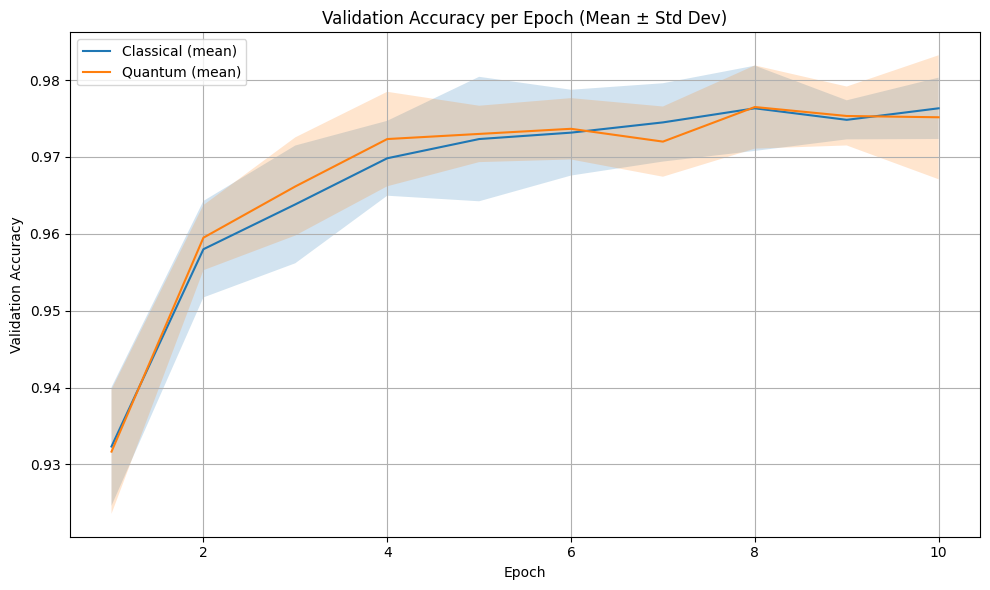

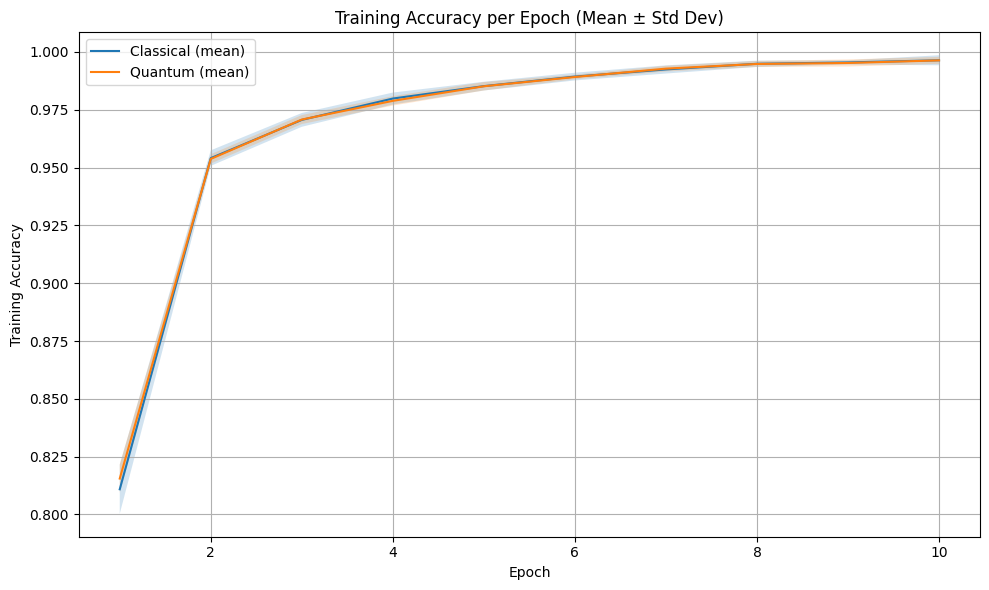

In [36]:
 #Load the CSV files (already saved from previous steps)
df_classical = pd.read_csv("results/cnn_baseline_metrics_10runs.csv")
df_quantum = pd.read_csv("results/quantum_augmented_metrics_10runs.csv")

# Add model labels if not already there
df_classical['model'] = 'classical'
df_quantum['model'] = 'quantum'

# Combine into one DataFrame for plotting
combined_df = pd.concat([df_classical, df_quantum], ignore_index=True)

# --- Plot Average Validation Accuracy per Epoch ---
plt.figure(figsize=(10, 6))
for model_type in ['classical', 'quantum']:
    model_df = combined_df[combined_df['model'] == model_type]
    grouped = model_df.groupby('epoch')['val_acc']
    mean_acc = grouped.mean()
    std_acc = grouped.std()
    plt.plot(mean_acc.index, mean_acc.values, label=f"{model_type.capitalize()} (mean)")
    plt.fill_between(mean_acc.index, mean_acc - std_acc, mean_acc + std_acc, alpha=0.2)

plt.title("Validation Accuracy per Epoch (Mean ± Std Dev)")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("results/val_accuracy_comparison.png")
plt.show()

# --- Plot Average Training Accuracy per Epoch ---
plt.figure(figsize=(10, 6))
for model_type in ['classical', 'quantum']:
    model_df = combined_df[combined_df['model'] == model_type]
    grouped = model_df.groupby('epoch')['train_acc']
    mean_acc = grouped.mean()
    std_acc = grouped.std()
    plt.plot(mean_acc.index, mean_acc.values, label=f"{model_type.capitalize()} (mean)")
    plt.fill_between(mean_acc.index, mean_acc - std_acc, mean_acc + std_acc, alpha=0.2)

plt.title("Training Accuracy per Epoch (Mean ± Std Dev)")
plt.xlabel("Epoch")
plt.ylabel("Training Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("results/train_accuracy_comparison.png")
plt.show()


In [37]:
# --- Summary Statistics for Final Validation Accuracy ---
final_epoch = combined_df[combined_df['epoch'] == combined_df['epoch'].max()]
final_classical = final_epoch[final_epoch['model'] == 'classical']
final_quantum   = final_epoch[final_epoch['model'] == 'quantum']

classical_val_mean = final_classical['val_acc'].mean() * 100
classical_val_std  = final_classical['val_acc'].std()  * 100
quantum_val_mean   = final_quantum['val_acc'].mean()  * 100
quantum_val_std    = final_quantum['val_acc'].std()   * 100

print(f"Classical CNN final validation accuracy: {classical_val_mean:.2f}% ± {classical_val_std:.2f}%")
print(f"Quantum-augmented CNN final validation accuracy: {quantum_val_mean:.2f}% ± {quantum_val_std:.2f}%")

Classical CNN final validation accuracy: 97.63% ± 0.40%
Quantum-augmented CNN final validation accuracy: 97.52% ± 0.81%
